# Decision tree classifier: diabetes prediction

Absolutely minimal MVP (minimum viable product) solution. Use this as a starting point to fill in the meat of the project according to the outline in '[How to complete data science projects for submission](https://github.com/4GeeksAcademy/gperdrizet-ds7-materials/blob/main/how_to/complete_data-science_projects.md)'.

## 1. Data loading

### 1.1. Load

In [21]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
# Set random seed for notebook
random_seed=42

# Set train-test split fraction
testing_fraction=0.33

# Cross-validation method
cv_method=RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=random_seed)

# Class weighting for decision trees
class_weights=None

# Load the data from the URL
data_df=pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv")
data_df.drop_duplicates().reset_index(drop=True, inplace=True)

### 1.2. Train-test split

In [24]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing, setting the random seed
# so that we get the same test-train split every time we run the notebook
training_df, testing_df=train_test_split(
    data_df,
    test_size=testing_fraction,
    random_state=random_seed
)

# Reset the indexes
training_df.reset_index(inplace=True, drop=True)
testing_df.reset_index(inplace=True, drop=True)

In [25]:
# Get features and labels
training_labels=training_df['Outcome']
training_features=training_df.drop('Outcome', axis=1)

### 1.3. Inspect the data types

In [26]:
training_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               514 non-null    int64  
 1   Glucose                   514 non-null    int64  
 2   BloodPressure             514 non-null    int64  
 3   SkinThickness             514 non-null    int64  
 4   Insulin                   514 non-null    int64  
 5   BMI                       514 non-null    float64
 6   DiabetesPedigreeFunction  514 non-null    float64
 7   Age                       514 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 32.2 KB


In [27]:

training_labels.info()

<class 'pandas.core.series.Series'>
RangeIndex: 514 entries, 0 to 513
Series name: Outcome
Non-Null Count  Dtype
--------------  -----
514 non-null    int64
dtypes: int64(1)
memory usage: 4.1 KB


In [28]:
list(training_labels[:10])

[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]

### 1.4 Baseline decision tree classifier

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments={'Baseline': scores * 100}

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 69.9 +/- 4.4%



Model is 100.0% accurate on the training data
Fitted tree depth: 11

Feature importances:
 Pregnancies: 0.059
 Glucose: 0.362
 BloodPressure: 0.074
 SkinThickness: 0.061
 Insulin: 0.040
 BMI: 0.168
 DiabetesPedigreeFunction: 0.105
 Age: 0.131



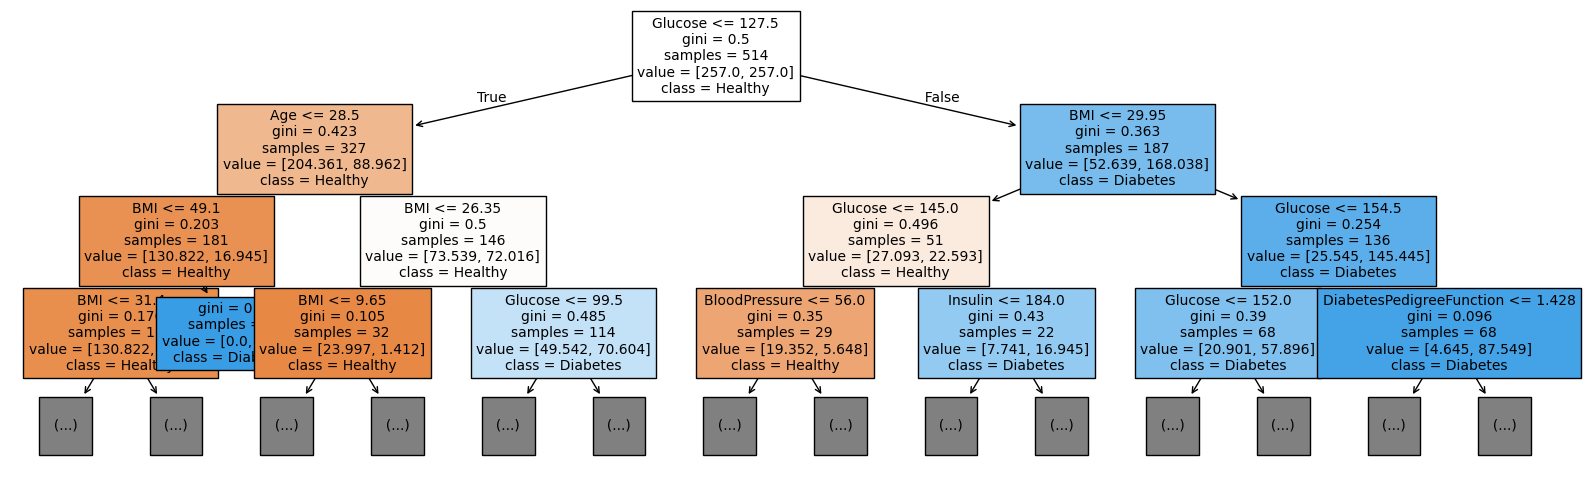

In [18]:
# Let's take a look at the tree
import matplotlib.pyplot as plt
from sklearn import tree

model=DecisionTreeClassifier(random_state=random_seed, class_weight='balanced')
fit_result=model.fit(training_features, training_labels)

# Make predictions from test set features
predicted_labels=model.predict(training_features)

# Score predictions for accuracy
percent_accuracy=accuracy_score(training_labels, predicted_labels) * 100

# Show some details about the model
print(f'\nModel is {percent_accuracy:.1f}% accurate on the training data')
print(f'Fitted tree depth: {fit_result.tree_.max_depth}')
print('\nFeature importances:')

for feature, importance in zip(training_features.columns, fit_result.tree_.compute_feature_importances()):
    print(f' {feature}: {importance:.3f}')

print()

# Plot the first few levels of the tree
fig=plt.figure(figsize=(20,6))

tree.plot_tree(model,
    feature_names=list(training_features.columns),
    class_names=['Healthy', 'Diabetes'],
    filled=True,
    fontsize=10,
    max_depth=3
)

plt.show()

## 2. EDA

### 2.1. Baseline model performance

In [29]:
# Define a reusable helper function for cross-validation here. We are going to
# be doing a lot of cross-validation, this allows us to reuse this code
# without having to copy-paste it over and over.

def cross_val(model, features: pd.DataFrame, labels: pd.Series) -> list[float]:
    '''Reusable helper function to run cross-validation on a model. Takes model,
    Pandas data frame of features and Pandas data series of labels. Returns 
    list of cross-validation fold accuracy scores as percents.'''

    # Define the cross-validation strategy
    cross_validation=StratifiedKFold(n_splits=7, shuffle=True, random_state=315)

    # Run the cross-validation, collecting the scores
    scores=cross_val_score(
        model,
        features,
        labels,
        cv=cross_validation,
        n_jobs=-1,
        scoring='accuracy'
    )

    # Print mean and standard deviation of the scores
    print(f'Cross-validation accuracy: {(scores.mean() * 100):.2f} +/- {(scores.std() * 100):.2f}%')

    # Return the scores
    return scores

In [30]:
# Instantiate a random forest classifier model
model=DecisionTreeClassifier(random_state=315)

# Run the cross-validation
scores=cross_val(model, training_features, training_labels)

Cross-validation accuracy: 68.86 +/- 4.21%


### 2.2. Missing and/or extreme values

In [31]:
# Features to look for zeros in
missing_data_features=['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

# Remove rows that have at least one zeros, using a copy, in case we decide it's a bad idea
filtered_training_df=training_df.copy()
filtered_training_df[missing_data_features]=filtered_training_df[missing_data_features].replace({0:np.nan})
filtered_training_df.dropna(inplace=True)

filtered_training_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000
mean,3.335878,124.019084,70.847328,28.904580,155.110687,32.856870,0.511737,30.832061,0.332061
std,3.124764,30.748074,12.670885,10.626832,120.283283,7.188289,0.349665,10.129546,0.471854
min,0.000000,56.000000,24.000000,10.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,100.000000,62.500000,21.000000,79.000000,27.500000,0.273000,23.000000,0.000000
50%,2.000000,120.000000,70.000000,28.500000,125.000000,32.800000,0.443500,27.000000,0.000000
75%,5.000000,143.000000,80.000000,36.000000,182.750000,37.175000,0.653000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### 2.3. Feature selection

Have 8 features for plot:
 0: Pregnancies
 1: Glucose
 2: BloodPressure
 3: SkinThickness
 4: Insulin
 5: BMI
 6: DiabetesPedigreeFunction
 7: Age


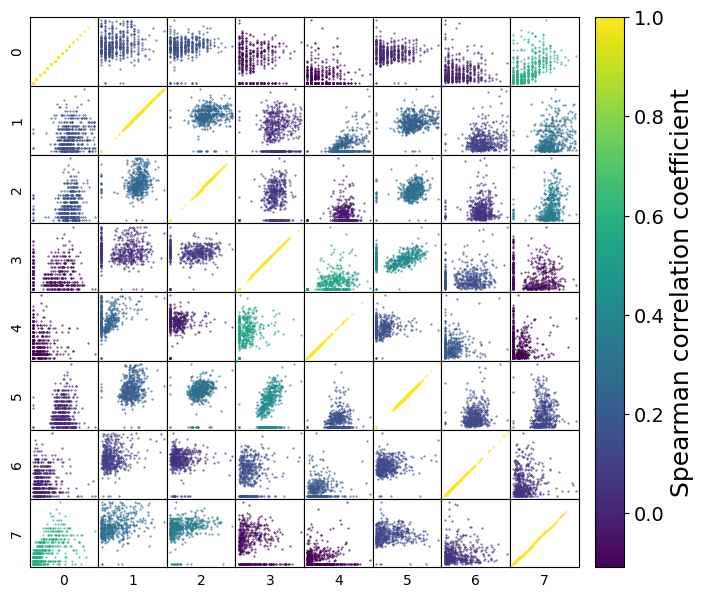

In [32]:
from notebook_helper_functions import plot_scatter_matrix

plot_scatter_matrix(training_features).show()

### 2.3.2. Feature mutual information

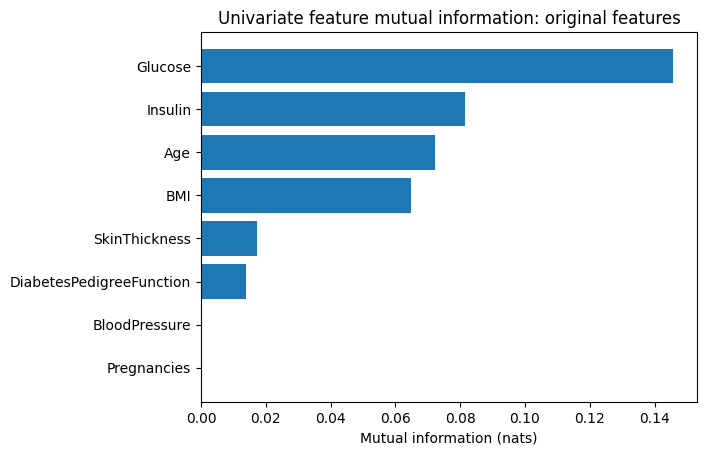

In [33]:
from sklearn.feature_selection import mutual_info_classif

results=mutual_info_classif(training_features, training_labels)

univariate_mi_results={}

for feature, result in zip(training_features.columns, results):
    univariate_mi_results[feature]=result

univariate_mi_results=dict(sorted(univariate_mi_results.items(), key=lambda item: item[1]))

plt.title('Univariate feature mutual information: original features')

plt.barh(
    np.arange(len(univariate_mi_results.values())),
    univariate_mi_results.values(),
    tick_label=list(univariate_mi_results.keys())
)

plt.xlabel('Mutual information (nats)')

plt.show()

In [34]:

manually_selected_feature_names=['Glucose','Insulin','BMI','Age']
manually_selected_training_features=training_features[manually_selected_feature_names]

In [35]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    manually_selected_training_features,
    training_labels,
    cv=cv_method,
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Manual feature selection']=scores * 100

print(f'Cross-validation accuracy: {(np.median(scores) * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 70.9 +/- 3.6%


## 3. Model training

In [36]:
print(filtered_training_df.columns)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


In [37]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb


X = filtered_training_df.drop(columns='Outcome')  # Features (exclude target column)
y = filtered_training_df['Outcome']  # Target variable

# Step 2: Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Scale the features (important for models like Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train different models and evaluate them

# Logistic Regression Model
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_scaled, y_train)  # Train the model

# Predict on the test set
y_pred_logreg = logreg_model.predict(X_test_scaled)

# Evaluate the Logistic Regression model
print("Logistic Regression Model Evaluation:")
print(classification_report(y_test, y_pred_logreg))
print(confusion_matrix(y_test, y_pred_logreg))

# Random Forest Classifier Model (Optional)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)  # Train the model without scaling

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model
print("Random Forest Model Evaluation:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

# XGBoost Classifier Model (Optional)
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)  # Train the model

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the XGBoost model
print("XGBoost Model Evaluation:")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

Logistic Regression Model Evaluation:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80        34
           1       0.65      0.58      0.61        19

    accuracy                           0.74        53
   macro avg       0.71      0.70      0.71        53
weighted avg       0.73      0.74      0.73        53

[[28  6]
 [ 8 11]]
Random Forest Model Evaluation:
              precision    recall  f1-score   support

           0       0.76      0.85      0.81        34
           1       0.67      0.53      0.59        19

    accuracy                           0.74        53
   macro avg       0.71      0.69      0.70        53
weighted avg       0.73      0.74      0.73        53

[[29  5]
 [ 9 10]]
XGBoost Model Evaluation:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        34
           1       0.72      0.68      0.70        19

    accuracy                           0.79     

## 4. Model optimization

### 4.1. Hyperparameter optimization

In [39]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

# Instantiate the model
model=DecisionTreeClassifier(random_state=315)

# Define the cross-validation strategy
cross_validation=StratifiedKFold(n_splits=7, shuffle=True, random_state=315)

# Define the hyperparameter search space
distributions={
    'max_depth': list(range(1, 50)),
    'min_samples_split': list(range(5, 50)),
    'min_samples_leaf': list(range(5, 50))
}

# Set-up the search
search=RandomizedSearchCV(
    model,
    distributions,
    scoring='accuracy',
    n_jobs=-1,
    cv=cross_validation,
    n_iter=50,
    random_state=315,
    return_train_score=True
)

results=search.fit(training_features, training_labels)
print(f'Best hyperparameters: {results.best_params_}')

Best hyperparameters: {'min_samples_split': 43, 'min_samples_leaf': 42, 'max_depth': 40}


### 4.2. Cross-validation of optimized model

In [41]:
#  Cross-validation for Logistic Regression
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Perform 5-fold cross-validation and compute mean score
logreg_cv_scores = cross_val_score(logreg_model, X, y, cv=5, scoring='accuracy')
print("Logistic Regression Cross-Validation Accuracy Scores:", logreg_cv_scores)
print("Logistic Regression Average Accuracy:", logreg_cv_scores.mean())

# Example: Cross-validation for RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Perform 5-fold cross-validation and compute mean score
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print("Random Forest Cross-Validation Accuracy Scores:", rf_cv_scores)
print("Random Forest Average Accuracy:", rf_cv_scores.mean())

Logistic Regression Cross-Validation Accuracy Scores: [0.86792453 0.73584906 0.84615385 0.76923077 0.78846154]
Logistic Regression Average Accuracy: 0.8015239477503628
Random Forest Cross-Validation Accuracy Scores: [0.8490566  0.77358491 0.75       0.76923077 0.82692308]
Random Forest Average Accuracy: 0.7937590711175616


In [42]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid for RandomForestClassifier
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [10, 20, None],      # Maximum depth of the tree
    'min_samples_split': [2, 5],      # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2]        # Minimum samples required to be at a leaf node
}

# Create GridSearchCV with 5-fold cross-validation
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                              param_grid=param_grid_rf, 
                              cv=5, 
                              scoring='accuracy', 
                              verbose=2, 
                              n_jobs=-1)

# Fit the grid search
grid_search_rf.fit(X, y)

# Best hyperparameters and best score from GridSearchCV
print("Best Parameters from Grid Search:", grid_search_rf.best_params_)
print("Best Cross-Validation Score from Grid Search:", grid_search_rf.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, min_samples

In [43]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Hyperparameter distribution for RandomForestClassifier
param_dist_rf = {
    'n_estimators': np.arange(50, 201, 50),  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40],     # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],         # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]            # Minimum samples required to be at a leaf node
}

# Create RandomizedSearchCV with 5-fold cross-validation
random_search_rf = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), 
                                      param_distributions=param_dist_rf, 
                                      n_iter=10,  # Number of random combinations to test
                                      cv=5, 
                                      scoring='accuracy', 
                                      verbose=2, 
                                      n_jobs=-1, 
                                      random_state=42)

# Fit the random search
random_search_rf.fit(X, y)

# Best hyperparameters and best score from RandomizedSearchCV
print("Best Parameters from Randomized Search:", random_search_rf.best_params_)
print("Best Cross-Validation Score from Randomized Search:", random_search_rf.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.3s
[CV] END max_depth=1

In [44]:
# Optimized RandomForest model using the best parameters
best_rf_model = RandomForestClassifier(**random_search_rf.best_params_, random_state=42)

# Perform cross-validation with the optimized model
rf_optimized_cv_scores = cross_val_score(best_rf_model, X, y, cv=5, scoring='accuracy')
print("Optimized Random Forest Cross-Validation Accuracy Scores:", rf_optimized_cv_scores)
print("Optimized Random Forest Average Accuracy:", rf_optimized_cv_scores.mean())

Optimized Random Forest Cross-Validation Accuracy Scores: [0.8490566  0.71698113 0.82692308 0.78846154 0.86538462]
Optimized Random Forest Average Accuracy: 0.8093613933236575


### 4.3. Final model evaluation

In [45]:
# final model evaluation using the best hyperparameters found from RandomizedSearchCV
final_model = RandomForestClassifier(**random_search_rf.best_params_, random_state=42)

# Training the model on the entire dataset 
final_model.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=4, n_estimators=np.int64(50),
                       random_state=42)

In [46]:
y_pred = final_model.predict(X_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.86        34
           1       0.76      0.68      0.72        19

    accuracy                           0.81        53
   macro avg       0.80      0.78      0.79        53
weighted avg       0.81      0.81      0.81        53

Confusion Matrix:
[[30  4]
 [ 6 13]]
ROC-AUC Score: 0.8204334365325078


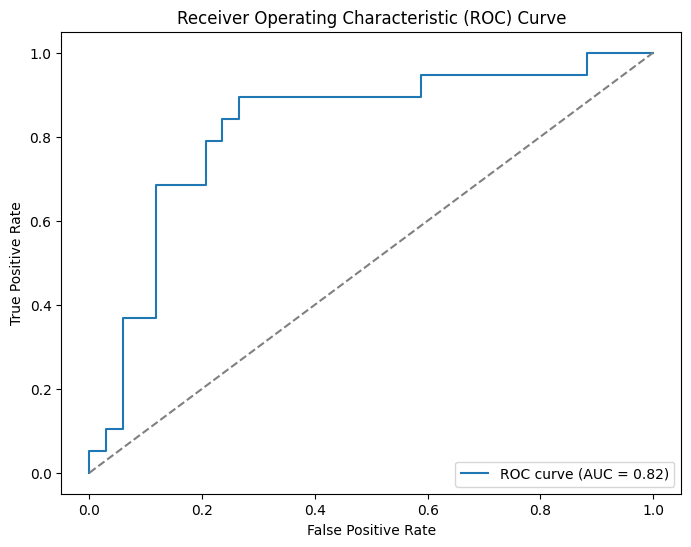

In [47]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Print classification report (precision, recall, F1-score, and support)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 2. Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 3. Compute the ROC-AUC score
y_pred_proba = final_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc}")

# 4. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [48]:
import joblib

# Save the trained model
joblib.dump(final_model, 'final_model_rf.pkl')

['final_model_rf.pkl']